In [18]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning / TS
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA

# Sklearn models & plumbing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)

warnings.filterwarnings("ignore")
RANDOM_STATE = 42



In [19]:
forecast_files = range(1, 7)
daily_peaks = None

for n in forecast_files:
    file_path = f"IESO-Ontario Demand 2022-2025 {n} day ahead.csv"
    df_temp = pd.read_csv(file_path)
    # Remove unnamed columns that may appear in the CSV
    df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
    # Create datetime and date columns
    df_temp['datetime'] = pd.to_datetime(df_temp['Date'] + ' ' + df_temp['Time'], dayfirst=True, errors='coerce')
    df_temp['date'] = df_temp['datetime'].dt.date
    # Aggregate to find daily maximum (peak) values for each predictor and the actual load
    agg = df_temp.groupby('date').agg({
        'ECA: IESO-Ontario Demand Historic Forecast': 'max',
        'RTO: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Actual': 'max'
    }).reset_index()

    # Rename prediction columns to reflect the forecast horizon. The actual peak is kept only for the 1‑day horizon.
    rename_map = {
        'ECA: IESO-Ontario Demand Historic Forecast': f'ECA_peak_{n}d',
        'RTO: IESO-Ontario Demand Historic Forecast': f'RTO_peak_{n}d',
        'TESLA: IESO-Ontario Demand Historic Forecast': f'TESLA_pred_peak_{n}d'
    }
    agg = agg.rename(columns=rename_map)
    if n == 1:
        agg = agg.rename(columns={'TESLA: IESO-Ontario Demand Actual': 'actual_peak'})
    else:
        # Drop the actual column for horizons other than 1 day ahead
        agg = agg.drop(columns=['TESLA: IESO-Ontario Demand Actual'])
    # Merge the current horizon's daily peaks into the master DataFrame
    if daily_peaks is None:
        daily_peaks = agg
    else:
        daily_peaks = pd.merge(daily_peaks, agg, on='date', how='outer')

# Build timestamp and calendar fields
daily_peaks = daily_peaks.sort_values('date').reset_index(drop=True)
daily_peaks['timestamp'] = pd.to_datetime(daily_peaks['date'])
daily_peaks = daily_peaks.drop(columns=['date'])
daily_peaks['year'] = daily_peaks['timestamp'].dt.year
daily_peaks['month'] = daily_peaks['timestamp'].dt.month
daily_peaks['day'] = daily_peaks['timestamp'].dt.day

# Drop rows with missing Actual (do NOT ffill/bfill targets)
daily_peaks = daily_peaks.dropna(subset=['actual_peak']).reset_index(drop=True)

daily_peaks.head()

,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d,actual_peak,ECA_peak_2d,RTO_peak_2d,TESLA_pred_peak_2d,ECA_peak_3d,RTO_peak_3d,TESLA_pred_peak_3d,...,ECA_peak_5d,RTO_peak_5d,TESLA_pred_peak_5d,ECA_peak_6d,RTO_peak_6d,TESLA_pred_peak_6d,timestamp,year,month,day
0,17310.5,17025.45,17025.45,16954.95,17475.6,17043.95,17043.95,17463.6,17010.40,17010.40,...,17463.6,17010.40,17010.40,17840.9,17581.75,17581.75,2022-01-01,2022,1,1
1,18871.0,19026.75,19026.75,18923.03,18786.2,18964.95,18964.95,18799.3,18996.50,18996.50,...,19558.7,19031.80,19031.80,19456.6,19394.10,19394.10,2022-01-02,2022,1,2
2,20130.1,20323.15,20323.15,20051.29,19924.1,20147.70,20147.70,19919.8,20304.15,20304.15,...,18846.3,19064.90,19064.90,18811.4,19031.55,19031.55,2022-01-03,2022,1,3
3,19548.8,19115.85,19115.85,19408.90,19387.7,19085.10,19085.10,19354.1,18939.90,18939.90,...,16516.5,16749.45,16749.45,16364.1,16493.05,16493.05,2022-01-04,2022,1,4
4,19494.2,19147.90,19147.90,19338.73,19794.5,19100.40,19100.40,19751.8,19011.60,19011.60,...,14541.7,14614.20,14614.20,14533.9,14699.70,14699.70,2022-01-05,2022,1,5


In [20]:
daily_peaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ECA_peak_1d         1227 non-null   float64       
 1   RTO_peak_1d         1227 non-null   float64       
 2   TESLA_pred_peak_1d  1227 non-null   float64       
 3   actual_peak         1227 non-null   float64       
 4   ECA_peak_2d         1227 non-null   float64       
 5   RTO_peak_2d         1227 non-null   float64       
 6   TESLA_pred_peak_2d  1227 non-null   float64       
 7   ECA_peak_3d         1227 non-null   float64       
 8   RTO_peak_3d         1227 non-null   float64       
 9   TESLA_pred_peak_3d  1227 non-null   float64       
 10  ECA_peak_4d         1227 non-null   float64       
 11  RTO_peak_4d         1227 non-null   float64       
 12  TESLA_pred_peak_4d  1227 non-null   float64       
 13  ECA_peak_5d         453 non-null    float64     

In [21]:
# Descriptive statistics
stats = daily_peaks[[
    'actual_peak',
    'ECA_peak_1d',
    'RTO_peak_1d',
    'TESLA_pred_peak_1d'
]].describe()
stats

,actual_peak,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d
count,1227.000000,1227.000000,1227.000000,1227.000000
mean,18135.832820,17856.211410,18093.216341,18093.216341
std,1879.666501,1619.048755,1846.455093,1846.455093
min,13303.840000,13631.700000,13696.100000,13696.100000
25%,16565.895000,16568.250000,16603.775000,16603.775000
50%,18139.780000,17909.000000,18103.450000,18103.450000
75%,19545.150000,19257.800000,19438.875000,19438.875000
max,23851.820000,21132.100000,24339.550000,24339.550000


In [22]:
# Check for missing values
missing = daily_peaks.isna().sum()
missing

ECA_peak_1d             0
RTO_peak_1d             0
TESLA_pred_peak_1d      0
actual_peak             0
ECA_peak_2d             0
RTO_peak_2d             0
TESLA_pred_peak_2d      0
ECA_peak_3d             0
RTO_peak_3d             0
TESLA_pred_peak_3d      0
ECA_peak_4d             0
RTO_peak_4d             0
TESLA_pred_peak_4d      0
ECA_peak_5d           774
RTO_peak_5d           774
TESLA_pred_peak_5d    774
ECA_peak_6d           774
RTO_peak_6d           774
TESLA_pred_peak_6d    774
timestamp               0
year                    0
month                   0
day                     0
dtype: int64

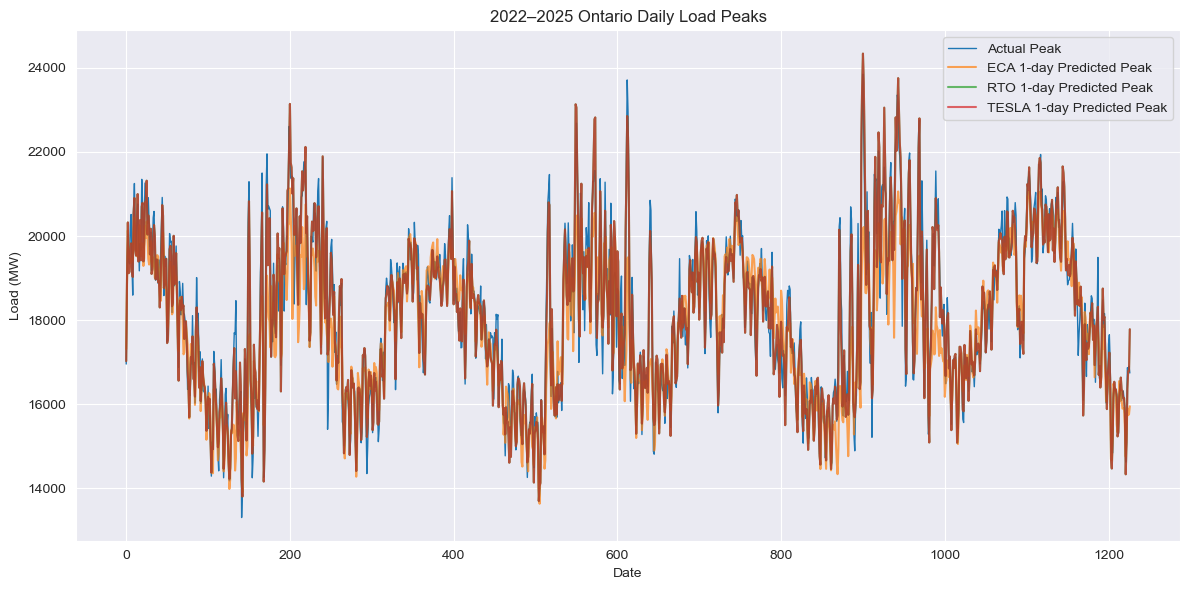

In [23]:
# Draw the trends of actual peaks and predicted peaks in chronological order
plt.figure(figsize=(12, 6))
plt.plot(daily_peaks.index, daily_peaks['actual_peak'], label='Actual Peak', linewidth=1.0)
plt.plot(daily_peaks.index, daily_peaks['ECA_peak_1d'], label='ECA 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['RTO_peak_1d'], label='RTO 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['TESLA_pred_peak_1d'], label='TESLA 1-day Predicted Peak', alpha=0.7)
plt.title('2022–2025 Ontario Daily Load Peaks')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

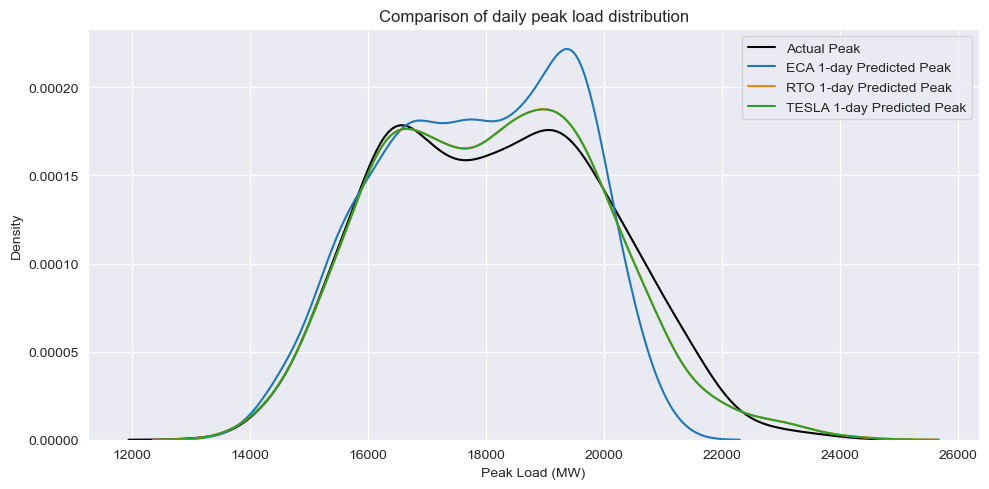

In [24]:
# Draw the distribution curve between the actual peak and the predicted peak
plt.figure(figsize=(10, 5))
for col, color, label in zip(['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d'],
                             ['black', 'tab:blue', 'tab:orange', 'tab:green'],
                             ['Actual Peak', 'ECA 1-day Predicted Peak', 'RTO 1-day Predicted Peak',
                              'TESLA 1-day Predicted Peak']):
    # Use KDE curves to display the distribution, do not enable fill to avoid dtype problems
    sns.kdeplot(daily_peaks[col], label=label, color=color, linewidth=1.5)
plt.title('Comparison of daily peak load distribution')
plt.xlabel('Peak Load (MW)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

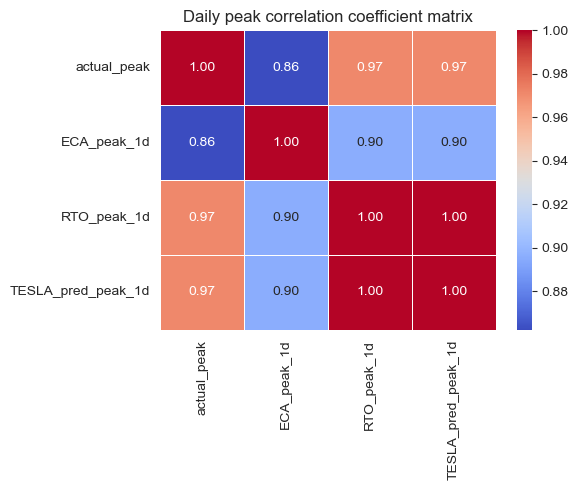

In [25]:
# Calculate the correlation coefficient matrix and draw the heat map
corr = daily_peaks[['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Daily peak correlation coefficient matrix')
plt.tight_layout()
plt.show()

In [26]:
# Label Monthly 4CP (Jun–Sep) — top 4 days by actual_peak *per month*
daily_peaks['is_CP'] = 0
summer_mask = daily_peaks['month'].between(6, 9)
for (y, m), sub in daily_peaks[summer_mask].groupby(['year', 'month']):
    if len(sub) < 20:  # skip partial months
        continue
    top_idx = sub.nlargest(4, 'actual_peak').index
    daily_peaks.loc[top_idx, 'is_CP'] = 1

daily_peaks[daily_peaks['is_CP'] == 1][['timestamp', 'actual_peak', 'year', 'month']].sort_values(
    ['year', 'month', 'actual_peak'], ascending=[True, True, False])

,timestamp,actual_peak,year,month
172,2022-06-22,21953.98,2022,6
166,2022-06-16,21499.52,2022,6
171,2022-06-21,21203.92,2022,6
174,2022-06-24,20714.83,2022,6
199,2022-07-19,22607.37,2022,7
200,2022-07-20,21850.29,2022,7
203,2022-07-23,21422.94,2022,7
201,2022-07-21,21378.51,2022,7
240,2022-08-29,21870.74,2022,8
218,2022-08-07,21778.08,2022,8


In [27]:
# Features and Split (ALL months). TS wrappers align to X; no scalers anywhere.
def pick_main_feature(cols):
    for cand in ['ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d']:
        if cand in cols:
            return cand
    return cols[0]


forecast_files = range(1, 7)
selected_feature = 'TESLA'  # or 'RTO', 'TESLA', or 'ALL'
feature_cols = []
if selected_feature == 'ECA':
    feature_cols = [f'ECA_peak_{n}d' for n in forecast_files]
elif selected_feature == 'RTO':
    feature_cols = [f'RTO_peak_{n}d' for n in forecast_files]
elif selected_feature == 'TESLA':
    feature_cols = [f'TESLA_pred_peak_{n}d' for n in forecast_files]
else:
    for base in ['ECA_peak', 'RTO_peak', 'TESLA_pred_peak']:
        for n in forecast_files:
            feature_cols.append(f'{base}_{n}d')

MAIN_FEAT = pick_main_feature(feature_cols)

model_df = daily_peaks[['timestamp', 'year', 'month', 'actual_peak', 'is_CP'] + feature_cols].copy()

# Split: ALL months — 2022–2023 train; 2024–2025 test
separation = 2024
train_df = model_df[model_df['year'] < separation].copy()
test_df = model_df[model_df['year'] >= separation].copy()

X_train = train_df[feature_cols]
y_train = train_df['is_CP'].astype(int).values
X_test = test_df[feature_cols]
y_test = test_df['is_CP'].astype(int).values

In [28]:
# --- TS wrappers fixed to align on X (no resizing hacks, no scalers) ---
class ARIMAClassifier:
    def __init__(self, order=(2, 1, 2)):
        self.order = order
        self.model_ = None
        self.mu_ = None
        self.std_ = None

    def fit(self, X, y):
        series = pd.Series(X[MAIN_FEAT].values).dropna()
        if len(series) < 10:
            self.model_ = None
            return self
        try:
            self.model_ = ARIMA(series, order=self.order).fit()
            self.mu_ = float(series.mean())
            self.std_ = float(series.std() + 1e-9)
        except Exception:
            self.model_ = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model_ is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
        else:
            try:
                forecast = self.model_.forecast(steps=n)
                # Normalize to [0,1]
                z = (forecast - forecast.min()) / (forecast.max() - forecast.min() + 1e-12)
                probs = np.asarray(z).astype(float)
            except Exception:
                probs = np.full(n, 0.5, dtype=float)
        return np.column_stack([1 - probs, probs])


class LSTMClassifier:
    def __init__(self, seq_length=30, lstm_units=64):
        self.seq_length = seq_length
        self.lstm_units = lstm_units
        self.model = None

    def _make_sequences(self, series):
        s = np.asarray(series).astype(float).reshape(-1, 1)
        Xs, idx = [], []
        L = self.seq_length
        for i in range(len(s) - L):
            Xs.append(s[i:i + L])
            idx.append(i + L)  # label pos or prediction anchor
        return np.stack(Xs, axis=0), np.array(idx)

    def fit(self, X, y):
        series = X[MAIN_FEAT].values
        Xs, idx = self._make_sequences(series)
        if len(Xs) == 0:
            return self
        y_arr = y[idx]
        self.model = Sequential([
            Input(shape=(self.seq_length, 1)),
            LSTM(self.lstm_units, return_sequences=True),
            Dropout(0.2),
            LSTM(self.lstm_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
        try:
            self.model.fit(Xs, y_arr, epochs=30, batch_size=32, verbose=0,
                           callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)])
        except Exception:
            self.model = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
        else:
            series = X[MAIN_FEAT].values
            Xs, idx = self._make_sequences(series)
            if len(Xs) == 0:
                probs = np.full(n, 0.5, dtype=float)
            else:
                p = self.model.predict(Xs, verbose=0).flatten()
                # align to n by padding first seq_length with min prob
                probs = np.full(n, float(p.min()) if len(p) > 0 else 0.5, dtype=float)
                probs[idx] = p
        return np.column_stack([1 - probs, probs])


class GRUClassifier:
    def __init__(self, seq_length=30, gru_units=64):
        self.seq_length = seq_length
        self.gru_units = gru_units
        self.model = None

    def _make_sequences(self, series):
        s = np.asarray(series).astype(float).reshape(-1, 1)
        Xs, idx = [], []
        L = self.seq_length
        for i in range(len(s) - L):
            Xs.append(s[i:i + L])
            idx.append(i + L)
        return np.stack(Xs, axis=0), np.array(idx)

    def fit(self, X, y):
        series = X[MAIN_FEAT].values
        Xs, idx = self._make_sequences(series)
        if len(Xs) == 0:
            return self
        y_arr = y[idx]
        self.model = Sequential([
            Input(shape=(self.seq_length, 1)),
            GRU(self.gru_units, return_sequences=True),
            Dropout(0.2),
            GRU(self.gru_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
        try:
            self.model.fit(Xs, y_arr, epochs=30, batch_size=32, verbose=0,
                           callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)])
        except Exception:
            self.model = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
        else:
            series = X[MAIN_FEAT].values
            Xs, idx = self._make_sequences(series)
            if len(Xs) == 0:
                probs = np.full(n, 0.5, dtype=float)
            else:
                p = self.model.predict(Xs, verbose=0).flatten()
                probs = np.full(n, float(p.min()) if len(p) > 0 else 0.5, dtype=float)
                probs[idx] = p
        return np.column_stack([1 - probs, probs])


In [29]:
models = {
    "Logistic Regression": Pipeline([('imp', SimpleImputer(strategy='median')),
                                     ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
    "Decision Tree": Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    "Random Forest": Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('clf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))]),
    "Extra Trees": Pipeline([('imp', SimpleImputer(strategy='median')),
                             ('clf', ExtraTreesClassifier(n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1))]),
    "Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                   ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))]),
    "AdaBoost": Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('clf', AdaBoostClassifier(random_state=RANDOM_STATE))]),
    "Hist Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                        ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
    "KNN": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', KNeighborsClassifier(n_neighbors=5))]),
    "SVM (Linear)": Pipeline([('imp', SimpleImputer(strategy='median')),
                              ('clf', SVC(kernel='linear', probability=True, random_state=RANDOM_STATE))]),
    "SVM (RBF)": Pipeline([('imp', SimpleImputer(strategy='median')),
                           ('clf', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))]),
    "GaussianNB": Pipeline([('imp', SimpleImputer(strategy='median')),
                            ('clf', GaussianNB())]),
    "LDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', LinearDiscriminantAnalysis())]),
    "QDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', QuadraticDiscriminantAnalysis(reg_param=0.1))]),
    "MLP": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE))]),
    # TS wrappers (no pipeline; they handle raw features internally)
    "ARIMA": ARIMAClassifier(order=(2, 1, 2)),
    "LSTM": LSTMClassifier(seq_length=30, lstm_units=64),
    "GRU": GRUClassifier(seq_length=30, gru_units=64),
}

results = []
proba_dict = {}

In [30]:
THRESH_PCTL = 0.95  # percentile threshold for determining high-load (CP) days
THRESH_FACTOR = 4  # weight multiplier applied to high-load days


def wei_classification(y_true, prob, threshold_percentile=THRESH_PCTL, weight_factor=THRESH_FACTOR):
    y_true_array = np.asarray(y_true).astype(float)
    prob = np.asarray(prob).astype(float)
    # quantile on labels (binary -> typically 1.0 if any positives)
    threshold = np.quantile(y_true_array, threshold_percentile)
    weights = np.where(y_true_array >= threshold, weight_factor, 1.0)
    weighted_error = np.abs(prob - y_true_array)
    total_w = weights.sum() + 1e-12
    wei = (weights * weighted_error).sum() / total_w
    tot_err = (weights * weighted_error).sum()
    if tot_err > 0:
        share = (weights[y_true_array >= threshold] * weighted_error[y_true_array >= threshold]).sum() / tot_err
    else:
        share = 0.0
    # return both the index and the share attributable to the high-weight class
    return float(wei), float(share)

In [31]:
# Train all models and compute probabilities on test
fitted_models = {}
prob_test = {}
for name, m in models.items():
    try:
        m.fit(X_train, y_train)
        fitted_models[name] = m
        if hasattr(m, "predict_proba"):
            s = m.predict_proba(X_test)[:, 1]
        else:
            # fall back to decision scores (should not happen for our set)
            s = m.decision_function(X_test)
            s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        prob_test[name] = s
    except Exception as e:
        print(f"[WARN] {name} failed during fit/predict: {e}")
        continue

# Overall trend metrics for 2024 only
test_2024 = test_df[test_df['year'] == 2024].copy()
X_2024 = test_2024[feature_cols]
y_2024 = test_2024['is_CP'].astype(int).values

overall_trend_2024 = {}
for name, m in fitted_models.items():
    try:
        s24 = m.predict_proba(X_2024)[:, 1] if hasattr(m, "predict_proba") else m.decision_function(X_2024)
        y_pred = (s24 >= 0.5).astype(int)
        precision = precision_score(y_2024, y_pred, zero_division=0)
        recall = recall_score(y_2024, y_pred, zero_division=0)
        f1 = f1_score(y_2024, y_pred, zero_division=0)
        accuracy = accuracy_score(y_2024, y_pred)
        auc_val = roc_auc_score(y_2024, s24) if len(np.unique(y_2024)) > 1 else np.nan
        wei_val, wei_share = wei_classification(y_2024, s24)
        overall_trend_2024[name] = {
            'Precision': precision,
            'Accuracy': accuracy,
            'Recall': recall,
            'AUC': auc_val,
            'F1score': f1,
            'WEI': wei_val,
            'WEI_share': wei_share
        }
    except Exception as e:
        overall_trend_2024[name] = {'Precision': np.nan, 'Accuracy': np.nan, 'Recall': np.nan, 'AUC': np.nan,
                                    'F1score': np.nan, 'WEI': np.nan, 'WEI_share': np.nan}
        print(f"[WARN] Trend metrics failed for {name}: {e}")

overall_trend_df_2024 = pd.DataFrame.from_dict(overall_trend_2024, orient='index').rename_axis('model').reset_index()
for col in ['Precision', 'Accuracy', 'Recall', 'AUC', 'F1score', 'WEI', 'WEI_share']:
    if col in overall_trend_df_2024.columns:
        overall_trend_df_2024[col] = overall_trend_df_2024[col].astype(float).round(4)

print("Overall trend metrics on 2024 (ALL months):")
display(overall_trend_df_2024.sort_values(['AUC', 'F1score', 'Precision'], ascending=[False, False, False]))

Overall trend metrics on 2024 (ALL months):


,model,Precision,Accuracy,Recall,AUC,F1score,WEI,WEI_share
0,Logistic Regression,0.5714,0.9645,0.7500,0.9680,0.6486,0.0564,1.0
8,SVM (Linear),0.6667,0.9727,0.7500,0.9673,0.7059,0.0468,1.0
10,GaussianNB,0.2121,0.8525,0.8750,0.9646,0.3415,0.1460,1.0
11,LDA,0.7143,0.9727,0.6250,0.9573,0.6667,0.0631,1.0
5,AdaBoost,0.4615,0.9508,0.7500,0.9488,0.5714,0.3115,1.0
3,Extra Trees,0.5217,0.9590,0.7500,0.9477,0.6154,0.0604,1.0
6,Hist Gradient Boosting,0.4800,0.9536,0.7500,0.9429,0.5854,0.0539,1.0
4,Gradient Boosting,0.4074,0.9426,0.6875,0.9422,0.5116,0.0682,1.0
2,Random Forest,0.4615,0.9508,0.7500,0.9247,0.5714,0.0611,1.0
7,KNN,0.6316,0.9699,0.7500,0.9143,0.6857,0.0514,1.0


In [32]:
# Monthly Precision@4 / Recall@4 for each model across the test period (Jun–Sep months)
def aggregated_p_r_at_4(df, scores):
    df = df.copy()
    df['score'] = scores
    total_hits = 0
    total_true = 0
    months = 0
    for (y, m), sub in df.groupby(['year','month']):
        if not (6 <= m <= 9):
            continue
        if len(sub) < 20:
            continue
        top4 = sub.nlargest(4, 'score')
        hits = int(top4['is_CP'].sum())
        denom = int(sub['is_CP'].sum())
        total_hits += hits
        total_true += denom
        months += 1
    precision4 = (total_hits / (4.0 * months)) if months > 0 else np.nan
    recall4 = (total_hits / total_true) if total_true > 0 else np.nan
    return precision4, recall4, months, total_true

rows = []
for name, s in prob_test.items():
    p4, r4, nmonths, tot_true = aggregated_p_r_at_4(test_df, s)
    rows.append({'Model': name, 'precision_at_4': p4, 'recall_at_4': r4})

p4r4_summary = pd.DataFrame(rows).sort_values('precision_at_4', ascending=False)
p4r4_summary['precision_at_4'] = p4r4_summary['precision_at_4'].round(4)
p4r4_summary['recall_at_4'] = p4r4_summary['recall_at_4'].round(4)

print("Aggregated Precision@4 / Recall@4 (single number per model):")
display(p4r4_summary[['Model','precision_at_4','recall_at_4']])

Aggregated Precision@4 / Recall@4 (single number per model):


,Model,precision_at_4,recall_at_4
0,Logistic Regression,0.7500,0.7500
8,SVM (Linear),0.7500,0.7500
10,GaussianNB,0.7500,0.7500
11,LDA,0.6875,0.6875
9,SVM (RBF),0.6250,0.6250
6,Hist Gradient Boosting,0.5625,0.5625
2,Random Forest,0.5625,0.5625
5,AdaBoost,0.5000,0.5000
3,Extra Trees,0.3750,0.3750
4,Gradient Boosting,0.3750,0.3750


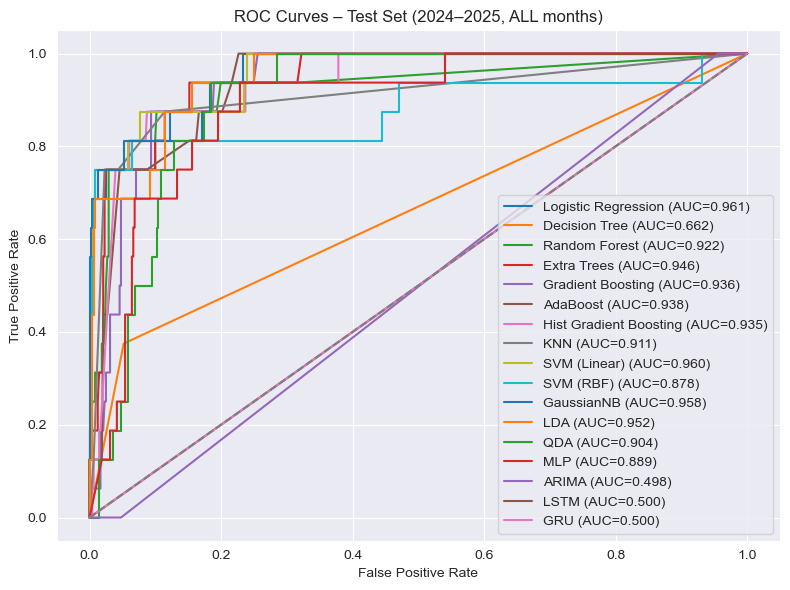

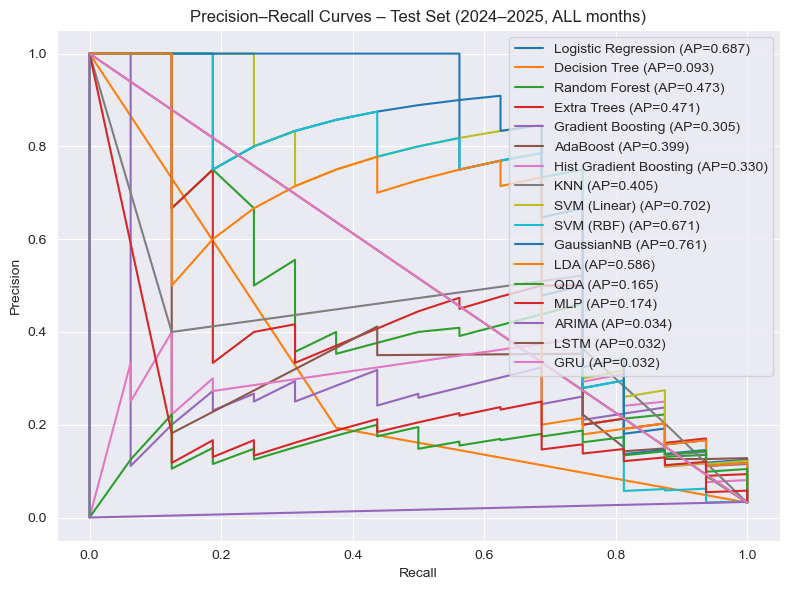

In [38]:
# ROC and Precision-Recall curves for 2024 (overall trend view)
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve as sk_roc_curve, auc as sk_auc

X_all = X_test
y_all = y_test

has_both_classes = (len(np.unique(y_all)) > 1)

# ROC
plt.figure(figsize=(8, 6))
plotted_any = False
if not has_both_classes:
    plt.text(0.5, 0.5, "ROC undefined for test set (single class in y).", ha='center', va='center')
else:
    for name, m in fitted_models.items():
        try:
            s = m.predict_proba(X_all)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_all)
            fpr, tpr, _ = sk_roc_curve(y_all, s)
            roc_auc_val = sk_auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.3f})")
            plotted_any = True
        except Exception:
            continue
    plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Test Set (2024–2025, ALL months)')
if plotted_any:
    plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
plt.figure(figsize=(8, 6))
plotted_any_pr = False
if y_all.sum() == 0:
    plt.text(0.5, 0.5, "PR undefined for test set (no positive class).", ha='center', va='center')
else:
    for name, m in fitted_models.items():
        try:
            s = m.predict_proba(X_all)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_all)
            precision, recall, _ = precision_recall_curve(y_all, s)
            ap_val = average_precision_score(y_all, s)
            plt.plot(recall, precision, label=f"{name} (AP={ap_val:.3f})")
            plotted_any_pr = True
        except Exception:
            continue

plt.xlabel('Recall');
plt.ylabel('Precision')
plt.title('Precision–Recall Curves – Test Set (2024–2025, ALL months)')
if plotted_any_pr:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [40]:
selected_model = "SVM (Linear)"  # change to any key in `models`
start_month, end_month = 6, 9

period_mask = (test_df['month'] >= start_month) & (test_df['month'] <= end_month)
period_data = test_df.loc[period_mask].copy()

if selected_model in fitted_models and not period_data.empty:
    mdl = fitted_models[selected_model]
    if hasattr(mdl, "predict_proba"):
        p = mdl.predict_proba(period_data[feature_cols])[:, 1]
    else:
        s = mdl.decision_function(period_data[feature_cols])
        p = (s - s.min()) / (s.max() - s.min() + 1e-12)
    period_data[f"{selected_model}_prob"] = p

    for year in sorted(period_data['year'].unique()):
        year_data = period_data[period_data['year'] == year]
        print(f"\n=== {year} results — {selected_model} ===")
        for month in sorted(year_data['month'].unique()):
            month_data = year_data[year_data['month'] == month]
            if len(month_data) < 1:
                continue
            sub = month_data[[f"{selected_model}_prob", "actual_peak", "is_CP", "timestamp"]].sort_values(
                f"{selected_model}_prob", ascending=False).head(4)
            display(sub)
            hits = int(sub['is_CP'].sum())
            total_cp_days = int(month_data['is_CP'].sum())
            precision4 = hits / 4.0
            print(f"Hits: {hits}/4 | True CP in month: {total_cp_days} | Precision@4: {precision4:.2%}")
            if total_cp_days > 0:
                recall4 = hits / total_cp_days
                print(f"Recall@4: {recall4:.2%}")
else:
    print("No data available for the selected model or period.")


=== 2024 results — SVM (Linear) ===


,SVM (Linear)_prob,actual_peak,is_CP,timestamp
900,0.991512,23851.82,1,2024-06-19
899,0.976383,23097.18,1,2024-06-18
901,0.894208,22485.78,1,2024-06-20
898,0.814411,21647.62,1,2024-06-17


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,SVM (Linear)_prob,actual_peak,is_CP,timestamp
920,0.953414,21836.21,0,2024-07-09
940,0.953346,22244.97,1,2024-07-29
926,0.948989,21637.19,0,2024-07-15
942,0.868142,23355.86,1,2024-07-31


Hits: 2/4 | True CP in month: 4 | Precision@4: 50.00%
Recall@4: 50.00%


,SVM (Linear)_prob,actual_peak,is_CP,timestamp
943,0.977480,23179.24,1,2024-08-01
969,0.956275,22749.83,1,2024-08-27
944,0.918841,22103.13,1,2024-08-02
968,0.876354,22466.42,1,2024-08-26


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,SVM (Linear)_prob,actual_peak,is_CP,timestamp
991,0.264484,20180.01,0,2024-09-18
989,0.198206,21546.47,1,2024-09-16
992,0.142151,20886.45,1,2024-09-19
985,0.124292,19582.95,0,2024-09-12


Hits: 2/4 | True CP in month: 4 | Precision@4: 50.00%
Recall@4: 50.00%
